In [1]:
import time

import pyvisa
from collect import get_volatage

import numpy as np
import scipy.signal.windows as wn
import scipy.spatial.transform as tr
from math import floor, ceil

from matplotlib import pyplot as plt

import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
rm = pyvisa.ResourceManager()
resources = rm.list_resources()
resources

('ASRL/dev/cu.debug-console::INSTR',
 'ASRL/dev/cu.Bluetooth-Incoming-Port::INSTR')

In [3]:
try:
    radar
except NameError:
    radar = rm.open_resource(resources[-1])
type(radar)

pyvisa.resources.usb.USBInstrument

In [4]:
start_f_GHz = 2.3
stop_f_GHz = 2.5
mode = "AUTOTRI"
ramp_time_ms = 4
num_sweeps = 1

voltage, times, sample_freq = get_volatage(
    radar, start_f_GHz, stop_f_GHz, mode, ramp_time_ms, num_sweeps
)

In [5]:
radar.write("SWEEP:TYPE?")
radar.read()

'2'

In [6]:
if mode == 'AUTOTRI':
    voltage[:,1::2,:] = voltage[:,1::2,::-1]
    #voltage = voltage.reshape(1, -1)

In [7]:
voltage.shape

(1, 51, 80)

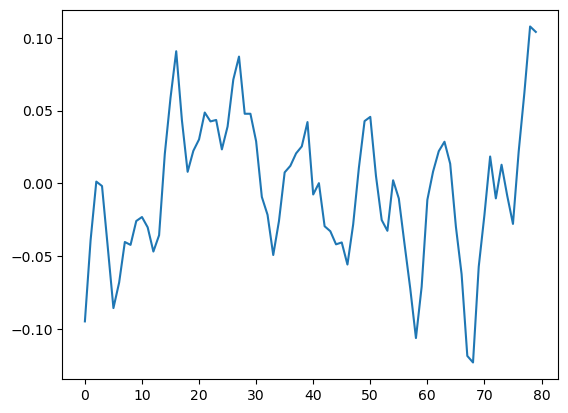

In [8]:
if mode == "AUTOTRI":
    plt.plot(voltage[0,2,:])
else:
    plt.plot(voltage[0])

In [9]:
ramp_samples = voltage.shape[-1]
nfft = ramp_samples*7
beats = (2*np.fft.fft(voltage, nfft, axis=-1)/ramp_samples)[...,0:nfft//2]
power = 20*np.log10(np.abs(beats))
phase = np.angle(beats)
freq_axis = (sample_freq/2) * np.linspace(0, 1, nfft//2)
range_axis = (3e8 * (ramp_time_ms/1000) * freq_axis) / \
    (2 * ((stop_f_GHz-start_f_GHz)*1e9))

ValueError: x and y must have same first dimension, but have shapes (280,) and (1, 51, 280)

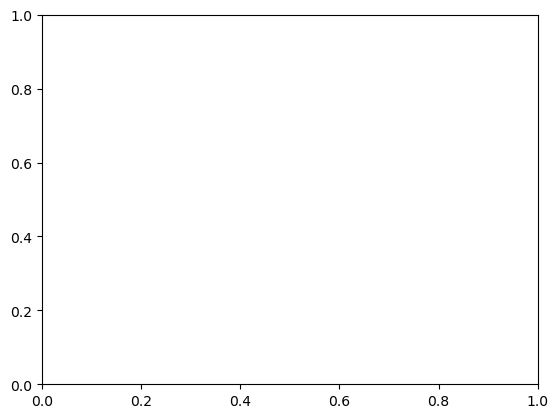

In [10]:
plt.plot(range_axis, power)

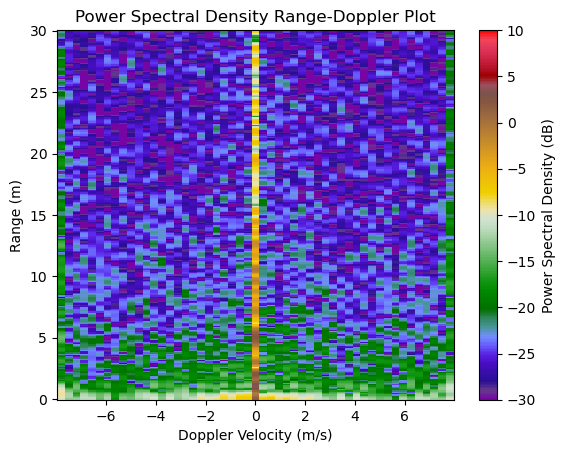

In [ ]:
if mode == "AUTOTRI":
    num_ramps = beats.shape[1]
    nvfft = num_ramps
    range_doppler = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(beats, nvfft, axis=1), axes=1)))
    va = (3e8/((stop_f_GHz+start_f_GHz)*(1e9/2))) / (4*ramp_time_ms/1000)
    v_axis = np.linspace(-va, va, nvfft)

    range_doppler = range_doppler[0].T
    plt.pcolormesh(v_axis, range_axis, range_doppler, vmin = -30, vmax = 10, cmap='pyart_Carbone42')

    plt.xlabel("Doppler Velocity (m/s)")
    plt.ylabel("Range (m)")
    plt.title("Power Spectral Density Range-Doppler Plot")
    cbar = plt.colorbar()
    cbar.set_label("Power Spectral Density (dB)")